# APTOS  2019 Blindness Detection

Doing this as my first attempt of learning fastai  http://www.fast.ai


Thanks To ilovescience https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter

@TODO
    Add more markdown / comments / links

## Setup (Download of kaggle dataset required. )

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
import os
os.listdir('./')

['dataBunch',
 'sample_submission.csv',
 'aptos.ipynb',
 'test.csv',
 'train_images',
 'Untitled.ipynb',
 'train.csv',
 'test_images',
 '.ipynb_checkpoints']

In [21]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

### Load data

In [23]:
base_image_dir = os.path.basename('./')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,diagnosis,path
0,2,train_images/a01c590c444f.png
1,1,train_images/22098b1fe461.png
2,0,train_images/83a63c4a3e4a.png
3,4,train_images/e821c1b6417a.png
4,0,train_images/bd06028eb7dd.png
5,3,train_images/6089fa333013.png
6,2,train_images/9b418ce42c13.png
7,0,train_images/c6a8f8f998a2.png
8,0,train_images/b72f59b85f7c.png
9,1,train_images/8bbd7835e9aa.png


There are 3662 images


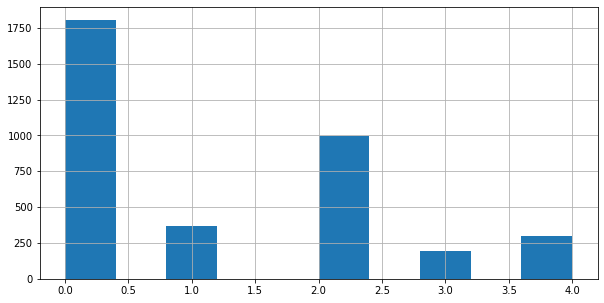

In [24]:
len_df = len(df)
print(f"There are {len_df} images")

df['diagnosis'].hist(figsize = (10, 5))


In [25]:
from PIL import Image

2416 1736


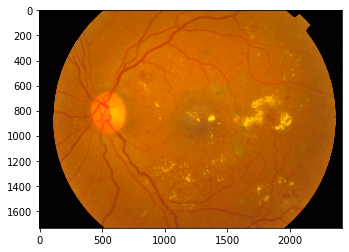

In [26]:
im = Image.open(df['path'][0])
width, height = im.size
print(width, height)
im.show()
plt.imshow(im)

In [27]:
doc(normalize)

In [28]:
sz = 224
bs = 64
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=180.,max_zoom=1.1,max_lighting=0.1,max_warp=0.,p_lighting=0.5)

In [29]:
src = (ImageList.from_df(df=df,path='./',cols='path')
           .split_by_rand_pct(0.2)
           .label_from_df(cols='diagnosis',label_cls=FloatList))

In [30]:
data = (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros')
       .databunch(bs=bs,num_workers=4)
       .normalize(imagenet_stats)
       )

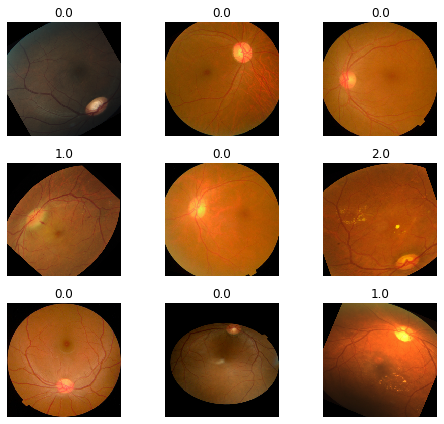

In [31]:
data.show_batch(rows=3, figsize=(7,6))


### Training